# Process MISR files

__I need to fix the time format and interpolate to the CAM 1deg grid__

### Add paths to run locally or off Cheyenne or Casper 
(what is the difference between these two again?)

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from interp_functions import *

In [3]:
import dask

### Load MISR data and fix the time format

In [8]:
ls /glade/work/jonahshaw/obs/MISR/cfmip_orig

clMISR_obs4MIPs_MISR_V7_20000301_20000331.nc
clMISR_obs4MIPs_MISR_V7_20000401_20000430.nc
clMISR_obs4MIPs_MISR_V7_20000501_20000531.nc
clMISR_obs4MIPs_MISR_V7_20000601_20000630.nc
clMISR_obs4MIPs_MISR_V7_20000701_20000731.nc
clMISR_obs4MIPs_MISR_V7_20000801_20000831.nc
clMISR_obs4MIPs_MISR_V7_20000901_20000930.nc
clMISR_obs4MIPs_MISR_V7_20001001_20001031.nc
clMISR_obs4MIPs_MISR_V7_20001101_20001130.nc
clMISR_obs4MIPs_MISR_V7_20001201_20001231.nc
clMISR_obs4MIPs_MISR_V7_20010101_20010131.nc
clMISR_obs4MIPs_MISR_V7_20010201_20010228.nc
clMISR_obs4MIPs_MISR_V7_20010301_20010331.nc
clMISR_obs4MIPs_MISR_V7_20010401_20010430.nc
clMISR_obs4MIPs_MISR_V7_20010501_20010531.nc
clMISR_obs4MIPs_MISR_V7_20010601_20010630.nc
clMISR_obs4MIPs_MISR_V7_20010701_20010731.nc
clMISR_obs4MIPs_MISR_V7_20010801_20010831.nc
clMISR_obs4MIPs_MISR_V7_20010901_20010930.nc
clMISR_obs4MIPs_MISR_V7_20011001_20011031.nc
clMISR_obs4MIPs_MISR_V7_20011101_20011130.nc
clMISR_obs4MIPs_MISR_V7_20011201_20011231.nc
clMISR_obs

In [4]:
misr_dir = '/glade/work/jonahshaw/obs/MISR/cfmip_orig/'
files = os.listdir('/glade/work/jonahshaw/obs/MISR/cfmip_orig/')

files_full = glob.glob('/glade/work/jonahshaw/obs/MISR/cfmip_orig/*')

In [10]:
files

['clMISR_obs4MIPs_MISR_V7_20100501_20100531.nc',
 'clMISR_obs4MIPs_MISR_V7_20060601_20060630.nc',
 'clMISR_obs4MIPs_MISR_V7_20021101_20021130.nc',
 'clMISR_obs4MIPs_MISR_V7_20130701_20130731.nc',
 'clMISR_obs4MIPs_MISR_V7_20170201_20170228.nc',
 'clMISR_obs4MIPs_MISR_V7_20040301_20040331.nc',
 'clMISR_obs4MIPs_MISR_V7_20020401_20020430.nc',
 'clMISR_obs4MIPs_MISR_V7_20061101_20061130.nc',
 'clMISR_obs4MIPs_MISR_V7_20101101_20101130.nc',
 'clMISR_obs4MIPs_MISR_V7_20140101_20140131.nc',
 'clMISR_obs4MIPs_MISR_V7_20101001_20101031.nc',
 'clMISR_obs4MIPs_MISR_V7_20110801_20110831.nc',
 'clMISR_obs4MIPs_MISR_V7_20170401_20170430.nc',
 'clMISR_obs4MIPs_MISR_V7_20071001_20071031.nc',
 'clMISR_obs4MIPs_MISR_V7_20080901_20080930.nc',
 'clMISR_obs4MIPs_MISR_V7_20120501_20120531.nc',
 'clMISR_obs4MIPs_MISR_V7_20160601_20160630.nc',
 'clMISR_obs4MIPs_MISR_V7_20110601_20110630.nc',
 'clMISR_obs4MIPs_MISR_V7_20050601_20050630.nc',
 'clMISR_obs4MIPs_MISR_V7_20051001_20051031.nc',
 'clMISR_obs4MIPs_MI

#### Single test file

In [5]:
misr1 = xr.open_dataset('%s/%s' % (misr_dir,files[0]))#,decode_times=False)


These values don't make sense, right?

All files 04/2000-06/2020:

In [5]:
misr_all = xr.open_mfdataset(files_full)#,decode_times=False)

### Calculate the total cloud amount

Sum over cloudtop height (cth) and cloud optical thickness (tau). Per Roger Marchand, do not include clouds with tau<0.3.

From Roj:
On masking: "That said, I would be reluctant to give much credence to grid cells that
don't have at least a few hundred pixels."

On tau bins: "So if I remember correctly, the data in Kay et al. [2012] is not the sum
over all bins and includes ONLY those with an optical depth > 0.3.   For
"total cloud fraction" meaning independent of height I think it is fine
(in my opinion good) to include those points with a CTH in the -1
histogram row.  But if you do that, do be aware that this means the
values you get for LOW + MID + HIGH cloud fraction will not sum to total
cloud fraction.  You should NOT put the CTH = -1 row in the "LOW" category!

I don't remember if we inlcuded the CTH==-1 row in Kay et al. [2012] for
total cloud fraction.   While I think it is preferable to include it, I
think it is fair for users to declare these as "failed retrieval" points
and track this is a separate fraction.

More importantly, You should NOT (typically) include points with OD <
0.3 (or the OD = -1 column).   The counts with values < 0.3 include
things like "cloud shadows", cloud edges & sub-pixel clouds, and haze
that you probably don't want to count as a cloud. I note, the "absolute
accuracy" of this these number is circa 5% in the global/zonal average
and trade cumulus cloud-area is really over estimated by cloud-fraction
counted simply as "pixels with some amount of cloud" / "total pixel".  
If you haven't read my 2010 review paper of MISR, MODIS and ISCCP
histograms, I recommend this as a good place to start for background on
this topic."

In [13]:
misr_all_clt = misr_all['clMISR'][:,2:,:,:,:].sum(['cth','tau']) # do not include the first two tau bins

Mask with samplesMISR, the best option here. Roj Marchand suggested using "a few hundred" pixels as a discriminatory.

In [14]:
misr_all_clt_msk = misr_all_clt.where(misr_all['samplesMISR']>300)

In [25]:
# misr_all_clt_msk.to_netcdf('/glade/u/home/jonahshaw/w/obs/MISR/cltmsk_MISR_20000301_20200531.nc')

In [16]:
misr_mod_fulltavg = misr_all_clt_msk.groupby('time.month').mean('time').mean('month')

In [73]:
# misr_mod_fulltavg.to_netcdf('/glade/u/home/jonahshaw/w/archive/taylor_files/2021_obs/MISR_CLDTOT_200003_202005.nc')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [17]:
misr_mod_fulltavg_w = add_weights(misr_mod_fulltavg)

In [19]:
clt_globavg = masked_average(misr_mod_fulltavg_w,weights=misr_mod_fulltavg_w['cell_weight'])

In [20]:
clt_globavg.values

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(70.64758441)

In [21]:
oldmisr_path = '/glade/u/home/jonahshaw/w/archive/taylor_files/2012_obs/MISR.CLDTOT_MISR.nc'

In [22]:
oldmisr_clt = add_weights(xr.open_dataset(oldmisr_path))

In [23]:
oldmisr_clt_globavg = masked_average(oldmisr_clt,weights=oldmisr_clt['cell_weight'])

In [24]:
oldmisr_clt_globavg.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:      ()
Data variables:
    CLDTOT_MISR  float64 70.74>

After excluding tau<0.3 and tau=-1, these values match up well.

Need to rotate the longitude coordinate first (don't know why interp_like doesn't handle this)

In [26]:
misr_mod_fulltavg_w['lon'] = (misr_mod_fulltavg_w['lon']+360) % 360

In [27]:
new_like_old = misr_mod_fulltavg_w.interp_like(oldmisr_clt)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'New obs - Old obs')

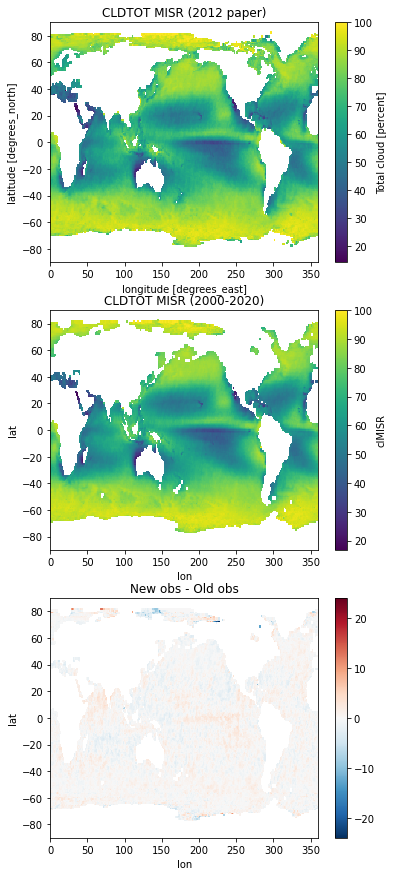

In [28]:
fig,axs = plt.subplots(3,1,figsize=(6,15))

oldmisr_clt['CLDTOT_MISR'].plot(ax=axs[0])
axs[0].set_title('CLDTOT MISR (2012 paper)')

new_like_old.plot(ax=axs[1])
axs[1].set_title('CLDTOT MISR (2000-2020)')

(new_like_old - oldmisr_clt['CLDTOT_MISR']).plot(ax=axs[2])
axs[2].set_title('New obs - Old obs')


The differences here are very small and don't seem concentrated anywhere.

#### MISR thick clouds are Tau>23, CTH<3km. The -1 values are for when Tau of cth were not retrieved, so I will ignore them when calculating the thick clouds then?

From Roj Marchand, about differences in low-thick clouds:

"I am surprised if this number is substantially different.   Perhaps you
are including the CTH = -1 row as a low cloud ?

In V6, there was a bug that caused some counts that should have gone
into the CTH = -1 row to instead go into the CTH 0 to 0.5 km row. So
"LOW" cloud fraction might change a bit.  If this is not a small change
do send me numbers / a picture so I can see better what has happened."

Here I want indices 6 and 7 (23-1000).

In [66]:
misr_all['tau_bnds'][0].values

array([[-1.00000000e+00, -1.00000000e+00],
       [ 0.00000000e+00,  3.00000012e-01],
       [ 3.00000012e-01,  1.29999995e+00],
       [ 1.29999995e+00,  3.59999990e+00],
       [ 3.59999990e+00,  9.39999962e+00],
       [ 9.39999962e+00,  2.30000000e+01],
       [ 2.30000000e+01,  6.00000000e+01],
       [ 6.00000000e+01,  1.00000000e+03]])

Here I want indices 1-6 (0-3km).

In [67]:
misr_all['cth_bnds'][0].values

array([[-1.0e+00, -1.0e+00],
       [ 0.0e+00,  5.0e+02],
       [ 5.0e+02,  1.0e+03],
       [ 1.0e+03,  1.5e+03],
       [ 1.5e+03,  2.0e+03],
       [ 2.0e+03,  2.5e+03],
       [ 2.5e+03,  3.0e+03],
       [ 3.0e+03,  4.0e+03],
       [ 4.0e+03,  5.0e+03],
       [ 5.0e+03,  7.0e+03],
       [ 7.0e+03,  9.0e+03],
       [ 9.0e+03,  1.1e+04],
       [ 1.1e+04,  1.3e+04],
       [ 1.3e+04,  1.5e+04],
       [ 1.5e+04,  1.7e+04],
       [ 1.7e+04,  2.3e+04]])

I select the indices that I want.

In [75]:
misr_all_clthick = misr_all['clMISR'][:,6:,1:7].sum(['cth','tau'])

Mask with the total cloud mask to include gridcells where low-thick MISR clouds are actually zero. Should slightly reduce the global average.

In [76]:
misr_all_clthick_msk = misr_all_clthick.where(misr_all['samplesMISR']>300) # need different order for this to work normally in the notebook

In [77]:
# Put longitude on the range [0,360] and sort so there aren't plotting issues.

misr_all_clthick_msk['lon'] = (misr_all_clthick_msk['lon']+360) % 360

misr_all_clthick_msk = misr_all_clthick_msk.sortby('lon')

Looks good.

In [78]:
misr_all_clthick_msk.to_netcdf('/glade/u/home/jonahshaw/w/obs/MISR/clthckmsk_MISR_20000301_20200531.nc')

In [79]:
misr_all_clthick_msk_tavg = misr_all_clthick_msk.groupby('time.month').mean('time').mean('month')

In [81]:
misr_all_clthick_msk_tavg

<xarray.DataArray 'clMISR' (lat: 180, lon: 360)>
dask.array<mean_agg-aggregate, shape=(180, 360), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5

In [82]:
misr_all_clthick_msk_tavg.to_netcdf('/glade/u/home/jonahshaw/w/archive/taylor_files/2021_obs/MISR_CLDTHCK_200003_202005.nc')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [65]:
oldmisr_path = '/glade/u/home/jonahshaw/w/archive/taylor_files/2012_obs/MISR.CLDLOW_THICK_MISR.nc'

oldmisr_thck = xr.open_dataset(oldmisr_path)['CLDLOW_THICK_MISR']

In [66]:
new_like_old = misr_all_clthick_msk_tavg.interp_like(oldmisr_thck)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'New obs - Old obs')

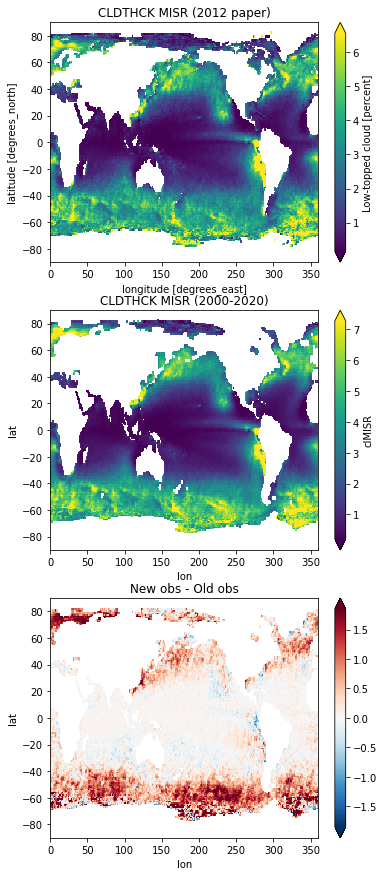

In [71]:
fig,axs = plt.subplots(3,1,figsize=(6,15))

oldmisr_thck.plot(ax=axs[0],robust=True)
axs[0].set_title('CLDTHCK MISR (2012 paper)')

new_like_old.plot(ax=axs[1],robust=True)
axs[1].set_title('CLDTHCK MISR (2000-2020)')

(new_like_old - oldmisr_thck).plot(ax=axs[2],robust=True)
axs[2].set_title('New obs - Old obs')


In [68]:
test1 = add_weights(new_like_old)
test2 = add_weights(oldmisr_thck)

cldthck_new_avg = masked_average(test1,weights=test1['cell_weight'])
cldthck_old_avg = masked_average(test2,weights=test2['cell_weight'])

In [70]:
print('Old MISR obs low-thick clouds: ', cldthck_old_avg.values)
print('New MISR obs low-thick clouds: ', cldthck_new_avg.values)

Old MISR obs low-thick clouds:  2.2454381647251602


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


New MISR obs low-thick clouds:  2.4457611362742213


In [71]:
test1 = add_weights(misr_all_clthick_msk)

In [73]:
test1b = test1.groupby('time.month').mean('time').mean('month')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


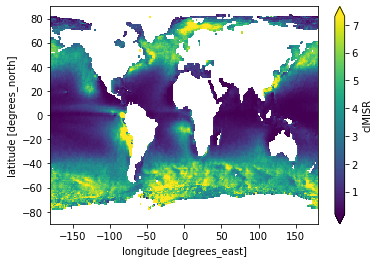

In [49]:
test1.groupby('time.month').mean('time').mean('month').plot(robust=True)

In [74]:
clthick_globavg = masked_average(test1b,weights=test1b['cell_weight'])

In [75]:
clthick_globavg.values

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(2.44700574)

In [24]:
oldmisr_path = '/glade/u/home/jonahshaw/w/archive/taylor_files/2012_obs/MISR.CLDLOW_THICK_MISR.nc'

In [32]:
oldmisr_thck = xr.open_dataset(oldmisr_path)['CLDLOW_THICK_MISR']

In [34]:
test2 = add_weights(oldmisr_thck)

In [35]:
oldmisr_clthck_globavg = masked_average(test2,weights=test2['cell_weight'])

In [36]:
oldmisr_clthck_globavg.values

array(2.24543816)

The difference is now fractionally small enough that I am going to ignore it. When I masked the low-thick cloud data with the low-thick cloud data, it artificially increased the global average to ~2.45. Masking with the MISR total cloud data reduces the average to 2.29, which is close enough to the 2012 data that I think we're good.

## This is old stuff below.

### Load CAM data for interpolation

In [5]:
case_dir = '/glade/scratch/jonahshaw/archive/Kay_COSP_2012/'

cam4metric = Cloud_Metric(case_dir)
cam4metric.add_case('cam4_1deg_release_amip',label='CAM4')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Loading MODIS cloud histograms...done.
Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.


### Plot to trigger variable loading

ValueError: x and y must have same first dimension, but have shapes (192,) and (8, 16, 192)

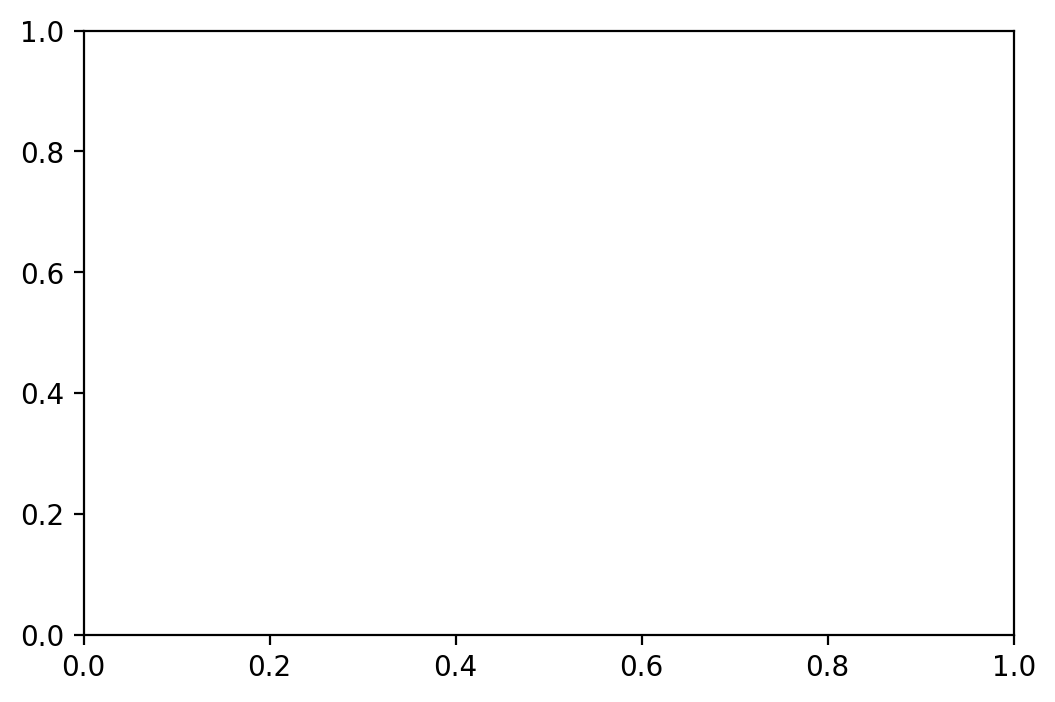

In [6]:
cam4metric.plot1D('CLD_MISR');

____

In [7]:
cam4da = cam4metric.get_case('cam4_1deg_release_amip').case_da

## Interpolate to the CAM grid

#### This takes kind of a long time...

In [13]:
%%time
misr_interpolated,_ = interp_like2D(misr1,cam4da['CLD_MISR'])

CPU times: user 1.84 s, sys: 222 ms, total: 2.06 s
Wall time: 2.49 s


### Copy over dataset-wide attributes

In [14]:
attrs = misr1.attrs
# print(attrs['Comments'])

datestamp = datetime.today().strftime("%Y/%m/%d")
attrs['Comments'] = 'Interpolated to 1.25x1 deg CESM grid by Jonah Shaw (CU) on %s.' % datestamp
# print(attrs['Comments'])
misr_interpolated = misr_interpolated.assign_attrs(attrs)

### Write python-ready file to Jonah obs directory

In [15]:
save_dir = '/glade/work/jonahshaw/obs/MISR/interp_0.9x1.25/'

In [16]:
filename = files[0]

In [17]:
dest_path = "%s/%s" % (save_dir,filename)
dest_path

'/glade/work/jonahshaw/obs/MISR/interp_0.9x1.25//clMISR_obs4MIPs_MISR_V7_20100501_20100531.nc'

In [18]:
misr_interpolated.to_netcdf(dest_path)

# Streamline with loops

In [19]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=8,
                     processes=16, memory="50GB",
                     project='UCUC0007',
                     queue='dav',
                     resource_spec='select=1:ncpus=4:mem=50G',
                     walltime='00:15:00')

cluster.scale(18)

from dask.distributed import Client
client = Client(cluster)
client


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43976 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://10.12.205.30:39667 Dashboard: http://10.12.205.30:43976/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [29]:
pwd

'/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/CESM2_COSP'

In [35]:
with Client(cluster) as client:
    client.wait_for_workers(1)
    client.upload_file('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/interp_functions.py')

distributed.core - ERROR - [Errno 2] No such file or directory: '/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/CESM2_COSP/dask-worker-space/dask-worker-space/worker-fn7mz1c7/interp_functions.py'
Traceback (most recent call last):
  File "/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/distributed/core.py", line 513, in handle_comm
    result = await result
  File "/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/distributed/scheduler.py", line 3039, in broadcast
    [send_message(address) for address in addresses if address is not None]
  File "/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/distributed/utils.py", line 229, in All
    result = await tasks.next()
  File "/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/distributed/scheduler.py", line 3033, in send_message
    resp = await send_recv(comm, close=True, serializers=serializers, **msg)
  File "/glade/work/jona

Exception: [Errno 2] No such file or directory: '/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/CESM2_COSP/dask-worker-space/dask-worker-space/worker-fn7mz1c7/interp_functions.py'

In [31]:
client.upload_file('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/interp_functions.py')

distributed.core - ERROR - [Errno 2] No such file or directory: '/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/CESM2_COSP/dask-worker-space/dask-worker-space/worker-yvui1ji6/interp_functions.py'
Traceback (most recent call last):
  File "/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/distributed/core.py", line 513, in handle_comm
    result = await result
  File "/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/distributed/scheduler.py", line 3039, in broadcast
    [send_message(address) for address in addresses if address is not None]
  File "/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/distributed/utils.py", line 229, in All
    result = await tasks.next()
  File "/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/distributed/scheduler.py", line 3033, in send_message
    resp = await send_recv(comm, close=True, serializers=serializers, **msg)
  File "/glade/work/jona

Exception: [Errno 2] No such file or directory: '/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/CESM2_COSP/dask-worker-space/dask-worker-space/worker-yvui1ji6/interp_functions.py'

In [24]:
og_dir = '/glade/work/jonahshaw/obs/MISR/cfmip_orig/'
save_dir = '/glade/work/jonahshaw/obs/MISR/interp_0.9x1.25/'

In [37]:
files = os.listdir(og_dir)

for i in files:
    filepath = "%s/%s" % (og_dir,i)
    outpath = "%s/%s" % (save_dir,i)
    print(filepath)
#     break
    ds = xr.open_dataset(filepath)
    
    ds_interpd,_ = interp_like2D(ds,cam4da['CLD_MISR'])  
    
    # Copy attributes over
    attrs = ds.attrs
    datestamp = datetime.today().strftime("%Y/%m/%d")
    attrs['Comments'] = 'Interpolated to 1.25x0.9 deg CESM grid and time format updated by Jonah Shaw (CU) on %s.' % datestamp
    # print(attrs['Comments'])
    ds_interpd = ds_interpd.assign_attrs(attrs)
    
    ds_interpd.to_netcdf(outpath)
    
#     break

/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20100501_20100531.nc
/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20060601_20060630.nc
/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20021101_20021130.nc
/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20130701_20130731.nc
/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20170201_20170228.nc
/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20040301_20040331.nc
/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20020401_20020430.nc
/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20061101_20061130.nc
/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20101101_20101130.nc
/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20140101_20140131.nc
/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20101001_20101031.nc
/glade/work/jonahshaw/obs/MISR/c

## Function for dask delayed calls

In [21]:
target = cam4da['CLD_MISR']

def interp_misr(og_dir,save_dir,file,target):
    filepath = "%s/%s" % (og_dir,file)
    outpath = "%s/%s" % (save_dir,file)
    print(filepath)

    ds = xr.open_dataset(filepath)
    
    ds_interpd,_ = interp_like2D(ds,target)  
    
    # Copy attributes over
    attrs = ds.attrs
    datestamp = datetime.today().strftime("%Y/%m/%d")
    attrs['Comments'] = 'Interpolated to 1.25x0.9 deg CESM grid and time format updated by Jonah Shaw (CU) on %s.' % datestamp
    # print(attrs['Comments'])
    ds_interpd = ds_interpd.assign_attrs(attrs)
    
    ds_interpd.to_netcdf(outpath)
    

In [22]:
files[1]

'clMISR_obs4MIPs_MISR_V7_20060601_20060630.nc'

In [25]:
%%time 
interp_misr(og_dir,save_dir,files[1],cam4da['CLD_MISR'])

/glade/work/jonahshaw/obs/MISR/cfmip_orig//clMISR_obs4MIPs_MISR_V7_20060601_20060630.nc
CPU times: user 1.93 s, sys: 265 ms, total: 2.19 s
Wall time: 2.36 s


## MISR data processing for cloud metric use

In [4]:
misr_dir = '/glade/work/jonahshaw/obs/MISR/interp_0.9x1.25/'
misr_files = os.listdir(misr_dir)

In [15]:
misr_filepaths = ['%s/%s' % (misr_dir,i) for i in misr_files]

#### This works! But takes ~30 seconds. Is there a better way?

#### Its 14gB!?!?

In [17]:
attempt1 = xr.open_mfdataset(misr_filepaths)

### Simplify so it is computationally cheaper

In [24]:
misr_tavg = attempt1['clMISR'].groupby('time.month')

In [27]:
misr_tavg2 = misr_tavg.mean('time') # monthly averages

In [30]:
misr_tavgf = misr_tavg2.mean('month') # total average, with equally weighted months (little bad)

### Write these smaller formats to the obs dir

In [36]:
tavg_out = '%s/%s' % (misr_dir,'clMISR_obs4MIPs_MISR_V7_monthly_averages.nc')
tavg_out

'/glade/work/jonahshaw/obs/MISR/interp_0.9x1.25//clMISR_obs4MIPs_MISR_V7_monthly_averages.nc'

In [37]:
tavg_outf = '%s/%s' % (misr_dir,'clMISR_obs4MIPs_MISR_V7_time_average.nc')
tavg_outf

'/glade/work/jonahshaw/obs/MISR/interp_0.9x1.25//clMISR_obs4MIPs_MISR_V7_time_average.nc'

In [39]:
misr_tavg2.to_netcdf(tavg_out)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
misr_tavgf.to_netcdf(tavg_outf)

In [ ]:
# Collect many calls for one compute

results = []
for x in L:
    y = dask.delayed(f)(x)
    results.append(y)

results = dask.compute(*results)

In [26]:
%%time

og_dir = '/glade/work/jonahshaw/obs/MISR/cfmip_orig/'
save_dir = '/glade/work/jonahshaw/obs/MISR/interp_0.9x1.25/'
target = cam4da['CLD_MISR']
files = os.listdir('/glade/work/jonahshaw/obs/MISR/cfmip_orig/')
# Loop through each hourly NetCDF file and save delayed dask instructions
results = []

for filename in files:
    print(filename)
    
    _task = dask.delayed(interp_misr)(og_dir,save_dir,filename,target)
    results.append(_task)

# Compute in parallel with dask. 
results = dask.compute(*results)

clMISR_obs4MIPs_MISR_V7_20100501_20100531.nc
clMISR_obs4MIPs_MISR_V7_20060601_20060630.nc
clMISR_obs4MIPs_MISR_V7_20021101_20021130.nc
clMISR_obs4MIPs_MISR_V7_20130701_20130731.nc
clMISR_obs4MIPs_MISR_V7_20170201_20170228.nc
clMISR_obs4MIPs_MISR_V7_20040301_20040331.nc
clMISR_obs4MIPs_MISR_V7_20020401_20020430.nc
clMISR_obs4MIPs_MISR_V7_20061101_20061130.nc
clMISR_obs4MIPs_MISR_V7_20101101_20101130.nc
clMISR_obs4MIPs_MISR_V7_20140101_20140131.nc
clMISR_obs4MIPs_MISR_V7_20101001_20101031.nc
clMISR_obs4MIPs_MISR_V7_20110801_20110831.nc
clMISR_obs4MIPs_MISR_V7_20170401_20170430.nc
clMISR_obs4MIPs_MISR_V7_20071001_20071031.nc
clMISR_obs4MIPs_MISR_V7_20080901_20080930.nc
clMISR_obs4MIPs_MISR_V7_20120501_20120531.nc
clMISR_obs4MIPs_MISR_V7_20160601_20160630.nc
clMISR_obs4MIPs_MISR_V7_20110601_20110630.nc
clMISR_obs4MIPs_MISR_V7_20050601_20050630.nc
clMISR_obs4MIPs_MISR_V7_20051001_20051031.nc
clMISR_obs4MIPs_MISR_V7_20160801_20160831.nc
clMISR_obs4MIPs_MISR_V7_20021201_20021231.nc
clMISR_obs

ModuleNotFoundError: No module named 'interp_functions'

# Old Work

### Find the files

In [38]:
testy = isccp_interpolated.groupby('time.month').mean('time')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [43]:
out = testy.mean('month')

In [48]:
isccpobs = out['cltisccp'] #.plot()

In [49]:
cam4isccp = cam4da['CLDTOT_ISCCP'].groupby('time.month').mean('time').mean('month')#.plot()

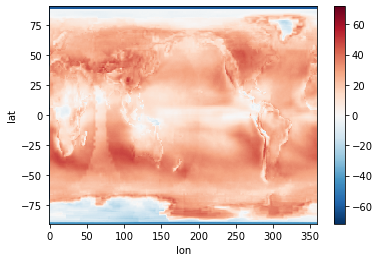

In [50]:
(isccpobs - cam4isccp).plot()

In [7]:
os.chdir('/glade/work/jenkay/obs/COSP')

In [8]:
ls

CALIPSO/  CLOUDSAT/  MISR/   readme_obs4COSP.txt
CERES/    ISCCP/     MODIS/  readme_obs4COSP.txt~


In [19]:
isccp_clt = xr.open_dataset('ISCCP/cltisccp_198307-200806.nc',decode_times=False)

isccp_clt['time'].attrs['units'] = isccp_clt['time'].attrs['units'] + '-01' # a little hacky

isccp_clt['time'].attrs['calendar'] = '360_day'

isccp_clt2 = xr.decode_cf(isccp_clt)

In [21]:
isccp_clt2

<xarray.Dataset>
Dimensions:    (latitude: 72, longitude: 144, time: 300)
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 -178.75 -176.25 -173.75 ... 176.25 178.75
  * time       (time) object 1983-07-01 00:00:00 ... 2008-06-01 00:00:00
Data variables:
    cltisccp   (time, latitude, longitude) float32 ...
Attributes:
    Description:   Simulator-oriented ISCCP total cloud fraction. Monthly data
    Conventions:   CF-1.4
    Coverage:      198307-200806
    References:    http://eosweb.larc.nasa.gov/PRODOCS/isccp/table_isccp.html
    Comments:      The equal-area monthly mean data are generated from the IS...
    Institution:   Lawrence Livermore National Lab
    Contact:       Yuying Zhang <zhang24@llnl.gov>
    CreationDate:  20101008

In [15]:
isccp_clt['time'].attrs['calendar']

'360_day'

### Time fix:

https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html

In [55]:
def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

isccp_clt = fix_calendar(isccp_clt,timevar='time')
isccp_clt = xr.decode_cf(isccp_clt)
isccp_clt

ValueError: unable to decode time units 'months since 1983-06' with "calendar '360_day'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [2]:
import cftime

In [3]:
cftime.num2date(0, 'months since 1960-01-01', '360_day')

cftime.Datetime360Day(1960, 1, 1, 0, 0, 0, 0)

In [68]:
cftime.num2date(0, 'months since 1983-06', '360_day')

cftime.Datetime360Day(1983, 6, 1, 0, 0, 0, 0)

In [60]:
isccp_clt.attrs

{'Description': 'Simulator-oriented ISCCP total cloud fraction. Monthly data',
 'Conventions': 'CF-1.4',
 'Coverage': '198307-200806',
 'References': 'http://eosweb.larc.nasa.gov/PRODOCS/isccp/table_isccp.html',
 'Comments': 'The equal-area monthly mean data are generated from the ISCCP-D1 data by Dr. Robert Pincus, University of Colorado',
 'Institution': 'Lawrence Livermore National Lab',
 'Contact': 'Yuying Zhang <zhang24@llnl.gov>',
 'CreationDate': '20101008',
 'calendar': '360_day'}

In [59]:
isccp_clt = isccp_clt.assign_attrs({'calendar': '360_day'})

In [63]:
xr.decode_cf(isccp_clt,decode_times='360')

ValueError: unable to decode time units 'months since 1983-06' with "calendar '360_day'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [76]:
isccp_clt['time'].attrs['calendar'] = '360_day'
xr.decode_cf(isccp_clt)

<xarray.Dataset>
Dimensions:    (latitude: 72, longitude: 144, time: 300)
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 -178.75 -176.25 -173.75 ... 176.25 178.75
  * time       (time) object 1983-07-01 00:00:00 ... 2008-06-01 00:00:00
Data variables:
    cltisccp   (time, latitude, longitude) float32 ...
Attributes:
    Description:   Simulator-oriented ISCCP total cloud fraction. Monthly data
    Conventions:   CF-1.4
    Coverage:      198307-200806
    References:    http://eosweb.larc.nasa.gov/PRODOCS/isccp/table_isccp.html
    Comments:      The equal-area monthly mean data are generated from the IS...
    Institution:   Lawrence Livermore National Lab
    Contact:       Yuying Zhang <zhang24@llnl.gov>
    CreationDate:  20101008
    calendar:      360_day

In [73]:
isccp_clt['time'].attrs['units'] = 'months since 1983-06-01'

In [74]:
isccp_clt['time'].attrs['units']

'months since 1983-06-01'

In [75]:
xr.decode_cf(isccp_clt)

ValueError: unable to decode time units 'months since 1983-06-01' with "calendar '360'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [44]:
isccp_clt = xr.open_dataset('ISCCP/cltisccp_198307-200806.nc',decode_times=True)

ValueError: unable to decode time units 'months since 1983-06' with 'the default calendar'. Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [10]:
isccp_clt = xr.open_dataset('ISCCP/cltisccp_198307-200806.nc',decode_times=False)

In [20]:
t150 = isccp_clt['cltisccp'].isel(time=150)

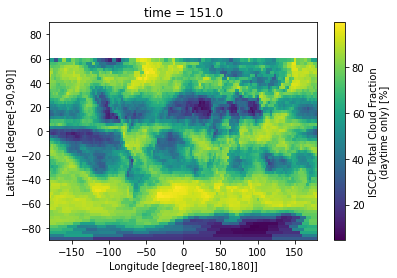

In [21]:
t150.plot()

In [27]:
attrs = {"units": "hours since 2000-01-01"}

ds = xr.Dataset({"time": ("time", [0, 1, 2, 3], attrs)})

out = xr.decode_cf(ds)

In [24]:
out

<xarray.Dataset>
Dimensions:  (time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T03:00:00
Data variables:
    *empty*